# Homework 3

## Auto-graded

The block below defines the necessary variables and shows a plot of the portion of IR spectrum that you will work with in this assignment:

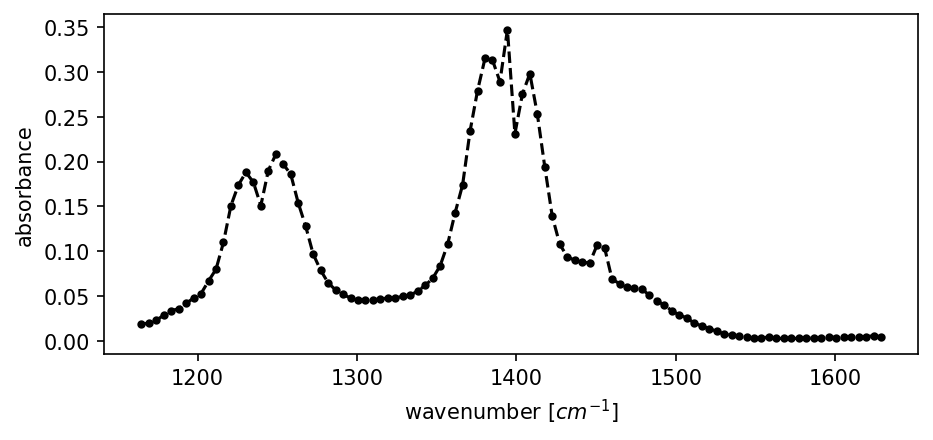

In [1]:
import numpy as np
import pylab as plt
import pandas as pd

df = pd.read_csv('ethanol_IR.csv')
x_peak = df['wavenumber [cm^-1]'].values[150:250].reshape(-1, 1)
y_peak = df['absorbance'].values[150:250]

fig, ax = plt.subplots(figsize = (7, 3), dpi = 150)
ax.plot(x_peak, y_peak, '--k', marker = '.')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

## 1. Linear Regression

We covered a simple linear regression in the last week's homework. A `LinearRegression` model was trained with `X` without any transformation to predict target values `y`. In this problem, you will make use of feature transformation and train a model with transformed features.

(1) Declare a `LinearRegression` model `lr` with `fit_intercept` set as `False`. Train the `lr` with `x_peak` to predict `y_peak` **without** any transformation. Save the predicted `y` values to the variable `yhat_peak`. (5 pts)

In [2]:
#################################
# Start your code here
from sklearn.linear_model import LinearRegression

lr = LinearRegression() #create a linear regression model instance

lr.fit(x_peak, y_peak) #fit the model (equivalent to the linear solve)

yhat_peak = lr.predict(x_peak) #create the model prediction (equivalent to the matrix multiplication)

#################################

In [3]:
from sklearn.metrics import r2_score
assert np.isclose(r2_score(y_peak, yhat_peak), 0.12400148257939236)

(2) Define a function `piecewise_linear` that creates a new non-parametric basis set consisting of piecewise linear functions for a given data vector `x`:

$X_{ij} = max(0, (x_i - x_j))$

The `piecewise_linear` function should take a single argument, `x`, which is a 2-dimensional `numpy` array of size `(N, 1)` where `N` is an arbitrary number, and should return a matrix of size `(N, N)`. (10 pts)

In [4]:
import pandas as pd
import numpy as np

def piecewise_linear(x):
#################################
# Start your code here
    N = len(x)
    X = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            X[i,j] = max(0, x[i] - x[j])
    return X
#################################

In [5]:
df = pd.read_csv('ethanol_IR.csv')
x_peak = df['wavenumber [cm^-1]'].values[150:250].reshape(-1, 1)
y_peak = df['absorbance'].values[150:250]

assert np.isclose(np.linalg.norm(piecewise_linear(x_peak)) * np.linalg.norm(piecewise_linear(y_peak.reshape(-1,1))), 116881.89667641501)

(3) Train the `lr` again to predict `y_peak`, but this time you will use the resulting piecewise quadratic functions from `x_peak`. (2.5 pts)

In [6]:
#################################
# Start your code here
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept = True) #create a linear regression model instance

lr.fit(piecewise_linear(x_peak), y_peak) #fit the model (equivalent to the linear solve)

y_peak = lr.predict(piecewise_linear(x_peak)) #create the model prediction (equivalent to the matrix multiplication)
#################################

In [7]:
lr.score(piecewise_linear(y_peak.reshape(-1,1)), y_peak)

-0.5003257177608627

In [8]:
df = pd.read_csv('ethanol_IR.csv')
x_peak = df['wavenumber [cm^-1]'].values[475:575].reshape(-1, 1)
y_peak = df['absorbance'].values[475:575]

assert np.isclose(lr.score(piecewise_linear(y_peak.reshape(-1, 1)), y_peak), -0.5003257177608791)

AssertionError: 

## 2. Cross-validation

k-fold cross-validation reduces the influence of random lucky/unlucky cases of prediction and provides more reliable error metrics than a simple hold-out approach does. In this problem, you will set up kernel regression and use 5-fold cross-validation to compute the average and standard deviation of mean absolute errors (MAE) for kernel regression on the `x_peak` and `y_peak` dataset.

(1) Import the `KFold` function from the scikit-learn package. Declare a 10-fold cross-validation object `kf` with `shuffle` set to `True`. (2.5 pts)

In [9]:
#################################
# Start your code here
from sklearn.model_selection import KFold
kf = KFold(n_splits = 10, shuffle = True) #validation object 
#################################

In [10]:
assert kf.n_splits == 10, "not a 10-fold CV"
assert kf.shuffle == True, "not shuffled"

(2) Create a function `rbf` that returns radial basis functions (RBF) for a given training set `x_train` and test set `x_test`. This function takes the following arguments:
- training set `x_train`: 1-D numpy array
- test set `x_test`: 1-D numpy array, default = `None`
- $\gamma$ `gamma`: float, default = 0.001

If `x_test` is passed as `None`, the function should return the RBF on `x_train` and `x_train`. (10 pts)

In [11]:
def rbf(x_train, x_test = None, gamma = 0.001):
#################################
# Start your code here
    if x_test is None:
        x_test = x_train
    N = len(x_test) #<- number of data points
    M = len(x_train) #<- number of features
    X = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            X[i,j] = np.exp(-gamma*(x_test[i] - x_train[j])**2)
    return X
#################################

In [12]:
assert np.isclose(np.linalg.norm(rbf(x_peak)), 28.686606236107515)

(3) Use the train/test indices defined below to train a kernel regression model on `x_peak` and `y_peak`. You should use a `LinearRegression(fit_intercept = True)` instance, and remember to use the RBF-transformed features to train and test the model. Use `gamma = 0.0001` and save the test set predictions as `yhat_test`. (10 pts)

Hint: Remember that you can use a list of indices to select data. For example, if `idxs = [0, 2]` then `x[idxs]` will return the 0th and 2nd items of `x`.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pylab as plt

In [14]:
train_index = range(0, 100, 2)
test_index = range(1, 101, 2)
gamma = 0.0001

#################################
# Start your code here
r2_test = []

for train_index, test_index in kf.split(x_peak):
    x_train, x_test = x_peak[train_index], x_peak[test_index]
    y_train, y_test = y_peak[train_index], y_peak[test_index]
    
    X_train = rbf(x_train, gamma=gamma) #RBF transformed X_Train

    model_rbf = LinearRegression(fit_intercept = True) #create a linear regression model instance
    model_rbf.fit(X_train, y_train) #fit the model
    r2 = model_rbf.score(X_train, y_train) #get the "score", which is equivalent to r^2
    print('r^2 training = {}'.format(r2))

    X_test = rbf(x_train, x_test=x_test, gamma=gamma) #RBF transformed X_Test

    yhat_test = model_rbf.predict(X_test) #create the model prediction

    r2 = model_rbf.score(X_test, y_test) #get the "score", which is equivalent to r^2
    print('r^2 testing = {}'.format(r2))
    r2_test.append(r2)


r^2 training = 0.9990082836781912
r^2 testing = 0.9975906982746727
r^2 training = 0.9897850781571655
r^2 testing = -0.6942756477270455
r^2 training = 0.9988551560173483
r^2 testing = 0.9989812384379697
r^2 training = 0.998972486347152
r^2 testing = 0.9975061930378323
r^2 training = 0.9988432334083566
r^2 testing = 0.9990584058342967
r^2 training = 0.9992068516696112
r^2 testing = 0.9952452819011168
r^2 training = 0.9988576998798199
r^2 testing = 0.9992269450974524
r^2 training = 0.999045977841924
r^2 testing = 0.9948685809770282
r^2 training = 0.9988560669842733
r^2 testing = 0.9993452700637985
r^2 training = 0.9988743939828606
r^2 testing = 0.9954855367838927


In [15]:
r2_score(yhat_test,y_peak[test_index])

0.995806996072468

In [16]:
assert np.isclose(r2_score(yhat_test, y_peak[test_index]), 0.9619274316420746)

AssertionError: 

(4) Report the average and standard deviation of MAE across the 10 runs of kernel regression on `x_peak` and `y_peak`. For each data split, a `LinearRegression(fit_intercept = True)` should be trained on the training set and tested on the test set. Be sure to use RBF-transformed features to train and test the models, and use gamma = `0.0001`. You have to compute the MAE of predictions on the test set. You should have a total of 10 MAEs (one for each split), and you will need to take the mean and the standard deviation of this set of MAEs.

Save the mean of MAEs to a variable called `mean` and the standard deviation to a variable called `std`. (10 pts)

Hints:

* If you successfully completed the prior problem, you can recycle much of the code.
* You will need to use the RBF kernel function to re-create the X matrix for each of the 10 random samples generated by the k-fold object.
* Remember that you will need both the `train` and `test` sets to generate the X matrix for the test set.
* If you are struggling with the RBF function you may use the `sklearn.metrics.pairwise.rbf_kernel` function.
* You can use the `sklearn.metrics.mean_absolute_error` function to calculate the MAE.

In [17]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pylab as plt

In [27]:
from numpy.random import seed
seed(1)
#################################
# Start your code here
kf = KFold(n_splits = 10, shuffle = True)

train_index = range(0, 100, 2)
test_index = range(1, 101, 2)
gamma = 0.0001

r2_test = []
mae_test =[]

for train_index, test_index in kf.split(x_peak):
    x_train, x_test = x_peak[train_index], x_peak[test_index]
    y_train, y_test = y_peak[train_index], y_peak[test_index]
    
    X_train = rbf(x_train, gamma=gamma) #RBF transformed X_Train

    model_rbf = LinearRegression(fit_intercept = True) #create a linear regression model instance
    model_rbf.fit(X_train, y_train) #fit the model
    r2 = model_rbf.score(X_train, y_train)#get the "score", which is equivalent to r^2
    
    #print('r^2 training = {}'.format(r2))

    X_test = rbf(x_train, x_test=x_test, gamma=gamma) #RBF transformed X_Test

    yhat_test = model_rbf.predict(X_test) #create the model prediction

    r2 = model_rbf.score(X_test, y_test) #get the "score", which is equivalent to r^2
    #print('r^2 testing = {}'.format(r2))
    mae = mean_absolute_error(y_test,yhat_test) #MAE of the test set
    
    
    r2_test.append(r2)
    mae_test.append(mae)

mean = np.mean(mae_test)
std = np.std(mae_test)

print("Mean of MAE:", mean)
print("STD of MAE:", std)
print("Mean*STD:", mean*std) 

print("Answer is in the range of 1e-5")
#################################

Mean of MAE: 0.0058607979524205435
STD of MAE: 0.0026809345680273303
Mean*STD: 1.571241582686803e-05
Answer is in the range of 1e-5


In [24]:
assert np.isclose(mean * std, 4.113118620485291e-05)

AssertionError: 

## Peer-graded

For the peer-graded section of the homework, we will work with another subset of the same dataset.

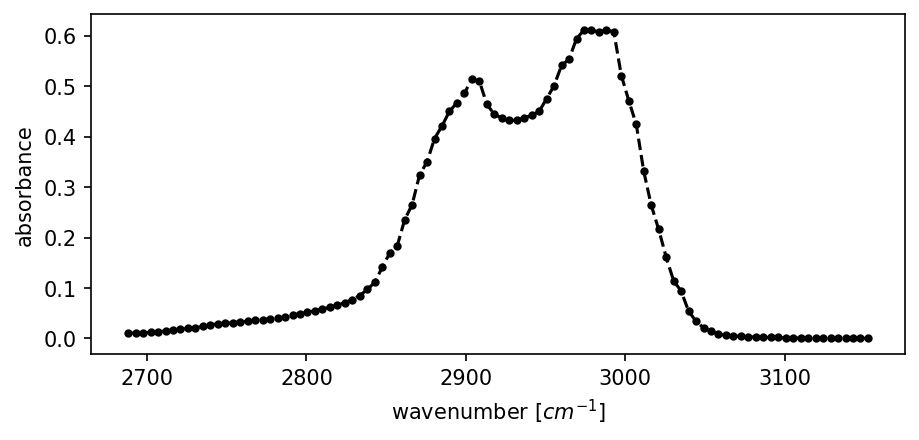

In [6]:
import pandas as pd
import numpy as np
import pylab as plt

df = pd.read_csv('ethanol_IR.csv')
x_peak = df['wavenumber [cm^-1]'].values[475:575].reshape(-1, 1)
y_peak = df['absorbance'].values[475:575]
fig, ax = plt.subplots(figsize = (7, 3), dpi = 150)
ax.plot(x_peak, y_peak, '--k', marker = '.')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

## 1. Interpolation

Select every third datapoint from `x_peak` and `y_peak`. Save them to `x_third` and `y_third`, respectively.

In [7]:
third = range(0,101,3)
x_third=x_peak[third]
y_third=y_peak[third]

Using these datapoints, train a `LinearRegression` model to predict the spectrum for all points in `x_peak`. Use piecewise linear functions for feature transformation, so that the result is a linear interpolation. Plot the prediction along with the original `y_peak`.

r^2 value: 0.9987645922591741


Text(0, 0.5, 'absorbance')

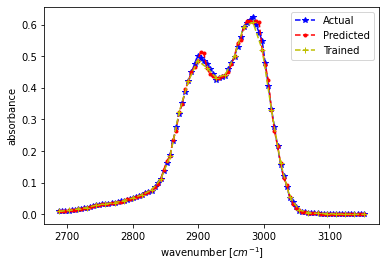

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import pylab as plt

#Defining the piecewise linear function
def piecewise_linear(x_train, x_test=None):
    if x_test is None:
        x_test = x_train
    N = len(x_test) #<- number of data points
    M = len(x_train) #<- number of features
    X = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            X[i,j] = max(0, x_test[i] - x_train[j])
    return X

lr = LinearRegression() #create a linear regression model instance

X_new =piecewise_linear(x_third, x_test=x_peak)

lr.fit(X_new, y_peak) #fit the model (equivalent to the linear solve)

yhat_peak = lr.predict(X_new) #create the model prediction (equivalent to the matrix multiplication)
print("r^2 value:",lr.score(X_new,y_peak))

fig, ax = plt.subplots()
ax.plot(x_peak,yhat_peak,'--b',marker='*') #plotting the model fitted yhat_peak
ax.plot(x_peak,y_peak,'--r',marker='.')#plotting the actual y_peak
ax.plot(x_third, y_third,'--y',marker='+')
ax.legend(['Actual','Predicted','Trained'])
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance')

Next, you will do the same interpolation with the radial basis functions and evaluate the performance of RBF kernels as a function of kernel width $\sigma$, where $\gamma = \frac{1}{2\sigma^2}$. The width of the RBF will vary as $\sigma=$ [1, 10, 50, 100, 150, 500]. Plot the prediction results along with the original `y_peak`. 

You should create a single plot for each $\sigma$, which means a total 6 of plots should be present. If you are interested in making compact and neat mutiple plots, the [`plt.subplots`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) function provides a very useful features.

Finally, create a model that is trained on `x_third` and `y_third` where $r^2 < 0$ for predictions on `y_peak`. You can use any model from the lectures or make one up. Note that you don't have to optimize the hyperparameters model. Plot the prediction along with `y_peak` and provide the resulting $r^2$.

Note: the purpose of this exercise is just to prove to yourself that it is possible to have a negative $r^2$ value, and see what the resulting model looks like. You should think about what the negative $r^2$ means, and how it might happen in a cross-validation setting.

r^2 value: 0.33185456828843174
r^2 value: 0.9992031161973826
r^2 value: 0.9990940851150629
r^2 value: 0.9988011436801898
r^2 value: 0.9954340189830204
r^2 value: 0.9310855227891321


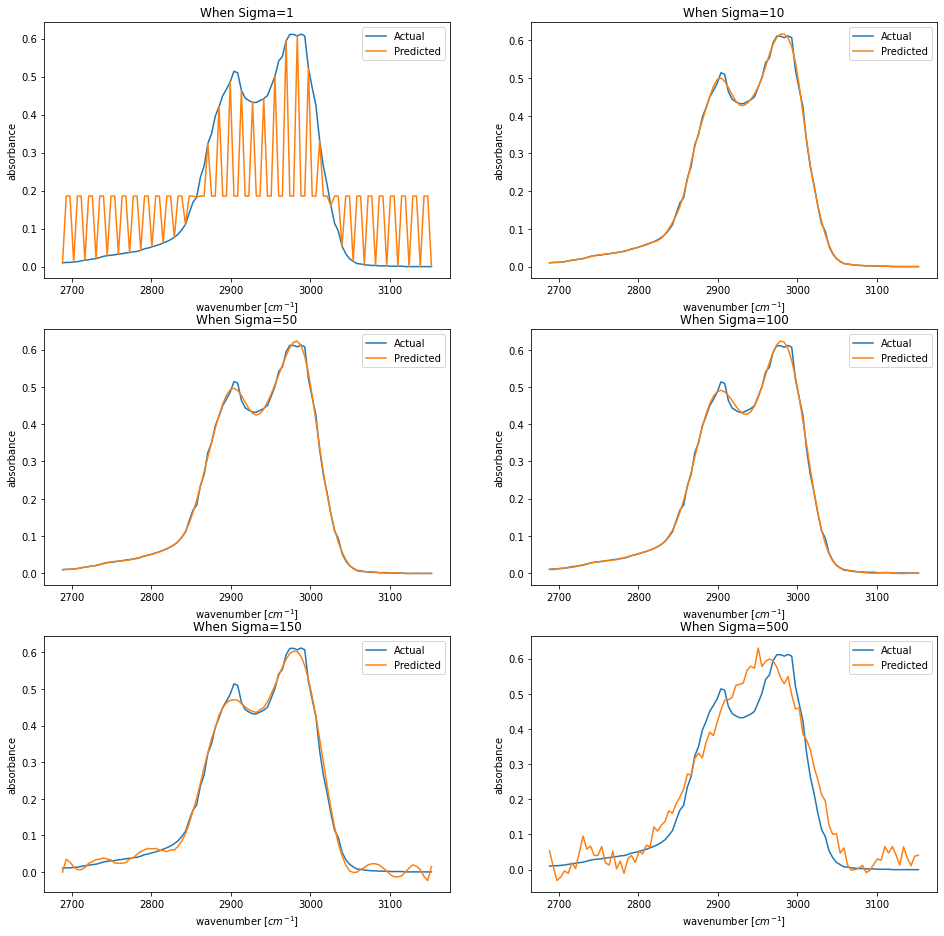

In [9]:
import pylab as plt

sigma=np.array([1,10,50,100,150,500])
gamma_old = 1/(2*sigma**2)
#print(gamma_old)

def rbf(x_train, x_test = None, Gamma=gamma):
    if x_test is None:
        x_test = x_train
    N = len(x_test) #<- number of data points
    M = len(x_train) #<- number of features
    X = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            X[i,j] = np.exp(-Gamma*(x_test[i] - x_train[j])**2)
    return X

yhat_peak_new =[]
for i in range(len(gamma_old)):
    gamma = gamma_old[i]
    
    lr = LinearRegression() 
    X = rbf(x_third, x_peak, gamma)
    lr.fit(X, y_peak)
    yhat_peak = lr.predict(X)
    print("r^2 value:",lr.score(X,y_peak))
    if i ==0:
        fig,ax =plt.subplots(3,2,figsize=(16,16))
        ax[0,0].plot(x_peak,y_peak)
        ax[0,0].plot(x_peak,yhat_peak)
        ax[0,0].set_title('When Sigma=1')
        ax[0,0].set_xlabel('wavenumber [$cm^{-1}$]')
        ax[0,0].set_ylabel('absorbance')
        ax[0,0].legend(['Actual','Predicted'])
        
    elif i == 1:
        ax[0,1].plot(x_peak,y_peak)
        ax[0,1].plot(x_peak,yhat_peak)
        ax[0,1].set_title('When Sigma=10')
        ax[0,1].set_xlabel('wavenumber [$cm^{-1}$]')
        ax[0,1].set_ylabel('absorbance')
        ax[0,1].legend(['Actual','Predicted'])
            
    elif i == 2:
        ax[1,0].plot(x_peak,y_peak)
        ax[1,0].plot(x_peak,yhat_peak)
        ax[1,0].set_title('When Sigma=50')
        ax[1,0].set_xlabel('wavenumber [$cm^{-1}$]')
        ax[1,0].set_ylabel('absorbance')
        ax[1,0].legend(['Actual','Predicted'])
        
    elif i == 3:
        ax[1,1].plot(x_peak,y_peak)
        ax[1,1].plot(x_peak,yhat_peak)
        ax[1,1].set_title('When Sigma=100')
        ax[1,1].set_xlabel('wavenumber [$cm^{-1}$]')
        ax[1,1].set_ylabel('absorbance')
        ax[1,1].legend(['Actual','Predicted'])
        
    elif i == 4:
        ax[2,0].plot(x_peak,y_peak)
        ax[2,0].plot(x_peak,yhat_peak)
        ax[2,0].set_title('When Sigma=150')
        ax[2,0].set_xlabel('wavenumber [$cm^{-1}$]')
        ax[2,0].set_ylabel('absorbance')
        ax[2,0].legend(['Actual','Predicted'])
        
    elif i == 5:
        ax[2,1].plot(x_peak,y_peak)
        ax[2,1].plot(x_peak,yhat_peak)
        ax[2,1].set_title('When Sigma=500')
        ax[2,1].set_xlabel('wavenumber [$cm^{-1}$]')
        ax[2,1].set_ylabel('absorbance')
        ax[2,1].legend(['Actual','Predicted'])



r^2 value: -0.0078141955257498


Text(0, 0.5, 'absorbance')

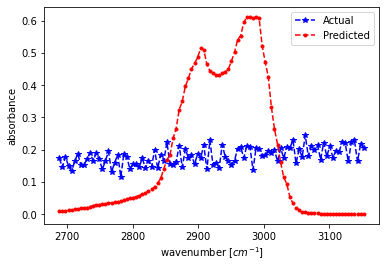

In [11]:
#creating a model for negative r^2 
def piecewise_linear(x_train, x_test=None):
    if x_test is None:
        x_test = x_train
    N = len(x_test) #<- number of data points
    M = len(x_train) #<- number of features
    X = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            #X[i,j] = max(0, 15*x_test[i] - x_train[j])
            X[i,j] = 10*x_test[i] - x_train[j]
    return X

lr = LinearRegression() #create a linear regression model instance

X_new =piecewise_linear(x_third, x_test=x_peak)

lr.fit(X_new, y_peak) #fit the model (equivalent to the linear solve)

yhat_peak = lr.predict(X_new) #create the model prediction (equivalent to the matrix multiplication)
print("r^2 value:",lr.score(X_new,y_peak))

fig, ax = plt.subplots()
ax.plot(x_peak,yhat_peak,'--b',marker='*') #plotting the model fitted yhat_peak
ax.plot(x_peak,y_peak,'--r',marker='.')#plotting the actual y_peak

ax.legend(['Actual','Predicted'])
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance')

## 2. Cauchy Kernel Matrix

Consider the Cauchy Kernel Matrix defined by

$C\left(x, x_0, \gamma \right)=\frac{1}{\pi\gamma}\frac{\gamma^2}{\left(x-x_0\right)^2+\gamma^2}$

where $x_0$ is the center of the distribution, which is comparable to the mean ($\mu$) of a Gaussian distribution. $\gamma$ is a scale factor that is comparable to the standard deviation ($\sigma$) of a Gaussian distribution.

Write a function that computes the Cauchy kernel between any two vectors $x_i$ and $x_j$.

In [12]:
def cauchy_kernel(x_train, x_test=None, gamma=1):
    if x_test is None: 
        x_test = x_train
    N = len(x_test)
    M = len(x_train)
    X = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            X[i,j] =((1/(np.pi*gamma)))*(gamma**2/((x_train[j]-x_test[i])**2 + gamma**2))
    return X

Visualize kernel matrices between `x_peak` and `x_peak` itself. Vary the $\gamma$ with [1, 10, 100]. You may want to use the [`plt.imshow`](https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.pyplot.imshow.html) function to visualize the matrices. Here is an example of using `plt.imshow`.

[[3.18309886e-01 1.38560218e-02 3.58091326e-03 ... 1.53964882e-06
  1.50838788e-06 1.47806943e-06]
 [1.38560218e-02 3.18309886e-01 1.38560218e-02 ... 1.57189174e-06
  1.53964882e-06 1.50838788e-06]
 [3.58091326e-03 1.38560218e-02 3.18309886e-01 ... 1.60515821e-06
  1.57189174e-06 1.53964882e-06]
 ...
 [1.53964882e-06 1.57189174e-06 1.60515821e-06 ... 3.18309886e-01
  1.38560218e-02 3.58091326e-03]
 [1.50838788e-06 1.53964882e-06 1.57189174e-06 ... 1.38560218e-02
  3.18309886e-01 1.38560218e-02]
 [1.47806943e-06 1.50838788e-06 1.53964882e-06 ... 3.58091326e-03
  1.38560218e-02 3.18309886e-01]]
[[3.18309886e-02 2.60968193e-02 1.69412263e-02 ... 1.53891190e-05
  1.50768057e-05 1.47739027e-05]
 [2.60968193e-02 3.18309886e-02 2.60968193e-02 ... 1.57112364e-05
  1.53891190e-05 1.50768057e-05]
 [1.69412263e-02 2.60968193e-02 3.18309886e-02 ... 1.60435726e-05
  1.57112364e-05 1.53891190e-05]
 ...
 [1.53891190e-05 1.57112364e-05 1.60435726e-05 ... 3.18309886e-02
  2.60968193e-02 1.69412263e-02]

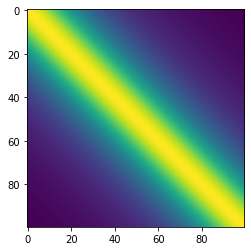

In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import pylab as plt


gamma = np.array([1,10,100])
for i in range(len(gamma)):
    x_new = cauchy_kernel(x_peak,x_peak,gamma[i])
    print(x_new)
    plt.imshow(x_new)

[[0.0031831  0.00317612 0.00315537 ... 0.00014686 0.00014401 0.00014125]
 [0.00317612 0.0031831  0.00317612 ... 0.00014979 0.00014686 0.00014401]
 [0.00315537 0.00317612 0.0031831  ... 0.00015281 0.00014979 0.00014686]
 ...
 [0.00014686 0.00014979 0.00015281 ... 0.0031831  0.00317612 0.00315537]
 [0.00014401 0.00014686 0.00014979 ... 0.00317612 0.0031831  0.00317612]
 [0.00014125 0.00014401 0.00014686 ... 0.00315537 0.00317612 0.0031831 ]]
[[0.00079577 0.00079567 0.00079534 ... 0.00034718 0.00034317 0.00033921]
 [0.00079567 0.00079577 0.00079567 ... 0.00035124 0.00034718 0.00034317]
 [0.00079534 0.00079567 0.00079577 ... 0.00035535 0.00035124 0.00034718]
 ...
 [0.00034718 0.00035124 0.00035535 ... 0.00079577 0.00079567 0.00079534]
 [0.00034317 0.00034718 0.00035124 ... 0.00079567 0.00079577 0.00079567]
 [0.00033921 0.00034317 0.00034718 ... 0.00079534 0.00079567 0.00079577]]
[[0.00045473 0.00045471 0.00045465 ... 0.0003198  0.00031784 0.00031589]
 [0.00045471 0.00045473 0.00045471 ... 

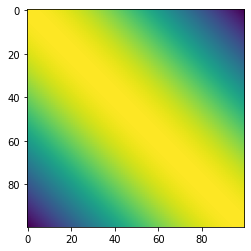

In [21]:
#if the gamma gets very large
gamma = np.array([100,400,700])
for i in range(len(gamma)):
    lr = LinearRegression()
    x_new = cauchy_kernel(x_peak,x_peak,gamma[i])
    print(x_new)
    plt.imshow(x_new)

[[3.18309886e+00 1.44800342e-03 3.62124404e-04 ... 1.53965619e-07
  1.50839495e-07 1.47807623e-07]
 [1.44800342e-03 3.18309886e+00 1.44800342e-03 ... 1.57189943e-07
  1.53965619e-07 1.50839495e-07]
 [3.62124404e-04 1.44800342e-03 3.18309886e+00 ... 1.60516622e-07
  1.57189943e-07 1.53965619e-07]
 ...
 [1.53965619e-07 1.57189943e-07 1.60516622e-07 ... 3.18309886e+00
  1.44800342e-03 3.62124404e-04]
 [1.50839495e-07 1.53965619e-07 1.57189943e-07 ... 1.44800342e-03
  3.18309886e+00 1.44800342e-03]
 [1.47807623e-07 1.50839495e-07 1.53965619e-07 ... 3.62124404e-04
  1.44800342e-03 3.18309886e+00]]
[[3.18309886e-01 1.38560218e-02 3.58091326e-03 ... 1.53964882e-06
  1.50838788e-06 1.47806943e-06]
 [1.38560218e-02 3.18309886e-01 1.38560218e-02 ... 1.57189174e-06
  1.53964882e-06 1.50838788e-06]
 [3.58091326e-03 1.38560218e-02 3.18309886e-01 ... 1.60515821e-06
  1.57189174e-06 1.53964882e-06]
 ...
 [1.53964882e-06 1.57189174e-06 1.60515821e-06 ... 3.18309886e-01
  1.38560218e-02 3.58091326e-03]

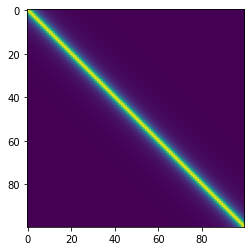

In [20]:
gamma = np.array([0.1,1,10])
for i in range(len(gamma)):
    lr = LinearRegression()
    x_new = cauchy_kernel(x_peak,x_peak,gamma[i])
    print(x_new)
    plt.imshow(x_new)

Briefly discuss the structure of these matrices. You should address at least two of the following questions:

* What is the meaning of a row in this matrix? What is the meaning of a column?
* How does the value of an entry change as a function of distance between the points?
* What happens as $\gamma$ gets very large or very small?
* How is the matrix different from or similar to a radial basis function kernel matrix?

## 3. Assumptions for Linear Regression

List the assumptions that must be valid for linear regression (and the corresponding uncertainty estimation based on standard deviation of the residuals) to be statistically rigorous.

**See the Module 2 Topic 2 Lesson 3 Slide 4.**

Assumptions of Linear Regression : 
    1. Linear Relationship - the dependent and the independent variables are linear 
    2. Multivariant Normality - All the variable's data should be normally distributed 
    3. Homoscedasticity - the error term is the same across all values of the independent variables
    4. Low Multicollinearity - Number of independent variables in multiple regression are closely related to each   other